# Парциальные корреляции 

Сетевой трафик представляем в виде обобщенных координаты и скорости, нормированных по флаговым состояниям:
$$
\tilde{x}_{\Delta T}^{(j)}(t_k) = \dfrac{x_{\Delta T}^{(j)}(t_k)}{D_{xy}(t_k)}, \quad \tilde{y}_{\Delta T}^{(j)} (t_k)= \dfrac{y_{\Delta T}^{(j)}(t_k)}{D_{xy}(t_k)}, \quad D_{xy}(t_k) = \sqrt{\sum_j^J\left(x_{\Delta T}^{(j)}(t_k)\right)^2 + \sum_j^J\left(y_{\Delta T}^{(j)}(t_k)\right)^2} + \varepsilon, \quad k=0, 1, \dots, K,
$$
где $\Delta T$ -интервал аггрегирования, $j$ - номер флагового состояния, $k$ - номер агрегата в момент времени $t_k$, 
$x_{\Delta t}^{(j)} = \sqrt{N_{\Delta t}^{(j)}(t_k)}$ - обобщенная координата, $y_{\Delta t}^{(j)}$ - обобщенная скорость,  $N_{\Delta t}^{(j)}(t_k)$ - число пакетов для $j$-м флагового состояния в $k$-м агрегате.

Далее $\Delta T$ отбросим.



Парциальные парные корреляции определяем следующим оператором:
$$
F = \mathop{trace} \left[ Q(t_k, t_{k-1}) \mathop{Re} S(t_k, t_{k-1})\right]
= \sum_{i=1}^J \sum_{j=1}^J s_{k,k-1}^{ij} q_{k,k-1}^{ji},
\quad k=1, 2, \dots, K,
$$
$S$ - оператор эволюции, $Q$ - информационный оператор.

Оператор эволюции $S$ описывает изменения фазового вектора  $\begin{vmatrix}\vec{x}_{\Delta T} (t_k) \\ i  \vec{y}_{\Delta T} (t_k) \end{vmatrix}$, двигающего по единичной гиперсфере. Его компоненты:
$$
s_{k,k-1}^{(ij)} = x_{k}^{(i)}x_{k-1}^{(j)} + y_{k}^{(i)}y_{k-1}^{(j)}
$$

Значения значимостей взаимного влияния информации составляют статистический информационный оператор $Q$:
$$
q^{(jj)}_{k,k-1} = \dfrac{I^{(j)}_{k} I^{(j)}_{k-1}}{\sum_j I^{(j)}_{k} I^{(j)}_{k-1} + \varepsilon},
\quad
q^{(jm)}_{k, k-1} = q^{(jj)}_{k,k-1} q^{(mm)}_{k,k-1}
$$
где $I^{(i)}(t_k)$ - длина $k$-го агрегата в $j$-ом лаговом состоянии.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import hilbert

## Агрегирование сетевого трафика

In [2]:
win = '50ms'
fname = 'vic-08-tcpcon-in.csv'  
epsilon = 1e-10

In [3]:
! head -3 vic-08-tcpcon-in.csv

frame.time;ip.src;ip.dst;tcp.flags;ip.len
Feb 11, 2019 16:08:25.870307316 MSK;192.168.18.16;192.168.64.16;0x00000010;40
Feb 11, 2019 16:08:25.870349983 MSK;192.168.18.16;192.168.64.16;0x00000010;40


In [4]:
signal_df = pd.read_csv(
    fname, sep=';', 
    usecols=['frame.time', 'tcp.flags', 'ip.len'])
signal_df.index = pd.to_datetime(signal_df['frame.time'])
signal_df.index = signal_df.index - signal_df.index[0]
signal_df.drop(['frame.time'], axis='columns', inplace=True)

In [5]:
flags_df = signal_df.pivot_table(
    index='frame.time',
    columns='tcp.flags', 
    values='ip.len', 
    aggfunc=np.sum,
    fill_value=0)

In [6]:
N = flags_df.resample(win).count().fillna(0)
I = flags_df.resample(win).mean().fillna(0)

## Обобщенные координаты, нормированные по флаговым состояниям

In [7]:
X = N ** 0.5
Y = pd.DataFrame(-hilbert(X.values, axis=0).imag)
Y.columns = X.columns
Y.set_index(X.index, inplace=True)
Dxy = np.sum(X**2, axis=1) + np.sum(Y**2, axis=1) + epsilon
Xn = X.divide(Dxy, axis=0)
Yn = Y.divide(Dxy, axis=0)

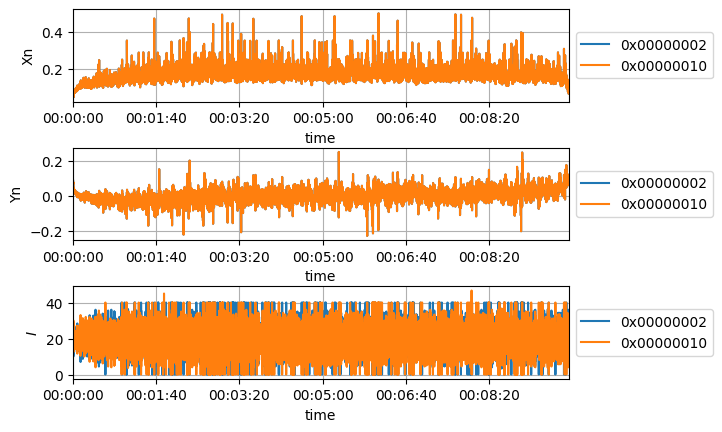

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=1)   
plt.subplots_adjust(wspace=0.5, hspace=0.5)

Xn.plot(ax=axes[0], grid=True)
axes[0].set_xlabel('time')
axes[0].set_ylabel('Xn')
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

Yn.plot(ax=axes[1], grid=True)
axes[1].set_xlabel('time')
axes[1].set_ylabel('Yn')
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

I.plot(ax=axes[2], grid=True)
axes[2].set_xlabel('time')
axes[2].set_ylabel('$I$')
axes[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.show()

## Степень информационной связи флаговых состояний

In [9]:
II = I[:-1].values * I[1:].values
Di = np.sum(II, axis=1).reshape(-1, 1) + epsilon
IIn = np.divide(II, Di)

## Вычисление значений парциальных корреляций

In [10]:
F_list = []
for k in range(1, Xn.shape[0]):
    
    x = Xn.iloc[k].values
    xp = Xn.iloc[k-1].values
    y = Yn.iloc[k].values
    yp = Yn.iloc[k-1].values
    S = np.outer(x, xp) + np.outer(y, yp)
    
    ii = IIn[k-1, :]
    Q = np.outer(ii, ii)
    np.fill_diagonal(Q, ii)
 
    F_list.append(np.tensordot(S, Q, axes=[[1, 0], [0, 1]]))
    
    # if k < 20:
    #     print(np.trace(Q))

F = np.array(F_list)

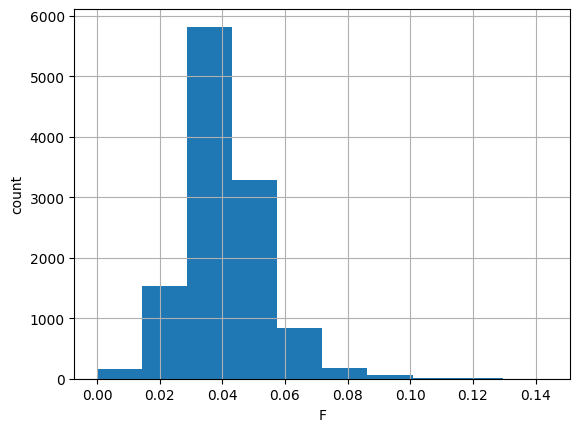

In [11]:
plt.hist(F)
plt.xlabel('F')
plt.ylabel('count')
plt.grid(True)
plt.show()